In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import copy
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr
from numcodecs.abc import Codec

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")
ERA5_U.shape

(1, 721, 1440)

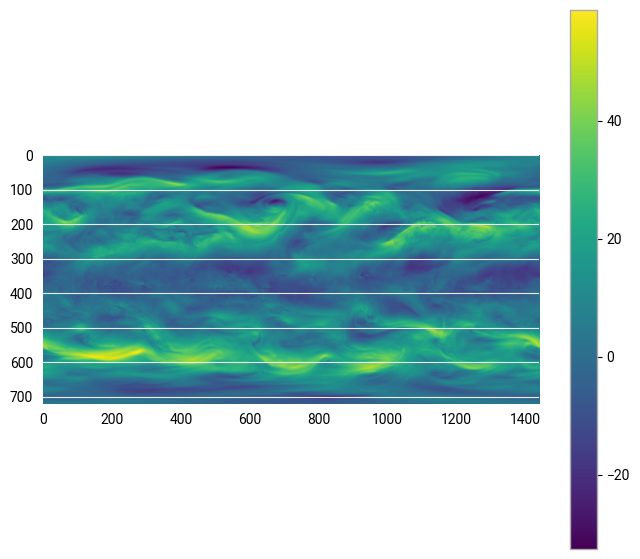

In [4]:
from matplotlib import pyplot as plt

plt.imshow(np.squeeze(ERA5_U.values))
plt.colorbar()
plt.show()

In [5]:
from compression_safeguards import Safeguards
from numcodecs_safeguards.lossless import Lossless

In [6]:
sg = Safeguards(
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="finite_difference(x, order=1, accuracy=2, type=0, axis=0, grid_spacing=1)",
            neighbourhood=[
                dict(axis=1, before=1, after=1, boundary="wrap"),
            ],
            type="abs",
            eb=0.1,
        )
    ]
)

In [7]:
correction_codec = Lossless().for_safeguards
correction_codec

CodecStack(PickBestCodec(HuffmanCodec(), CodecStack(BinaryDeltaCodec(), HuffmanCodec())), Zstd(level=3))

In [8]:
ERA5_U_prediction = np.zeros_like(ERA5_U.values)

In [9]:
ERA5_U_sg_correction = sg.compute_correction(ERA5_U.values, ERA5_U_prediction)
ERA5_U_sg = sg.apply_correction(ERA5_U_prediction, ERA5_U_sg_correction)

assert sg.check(ERA5_U.values, ERA5_U_sg)

In [10]:
ERA5_U_sg_encoded = correction_codec.encode(ERA5_U_sg_correction)
print(ERA5_U.nbytes / np.array(ERA5_U_sg_encoded).nbytes)

7.902031372489326


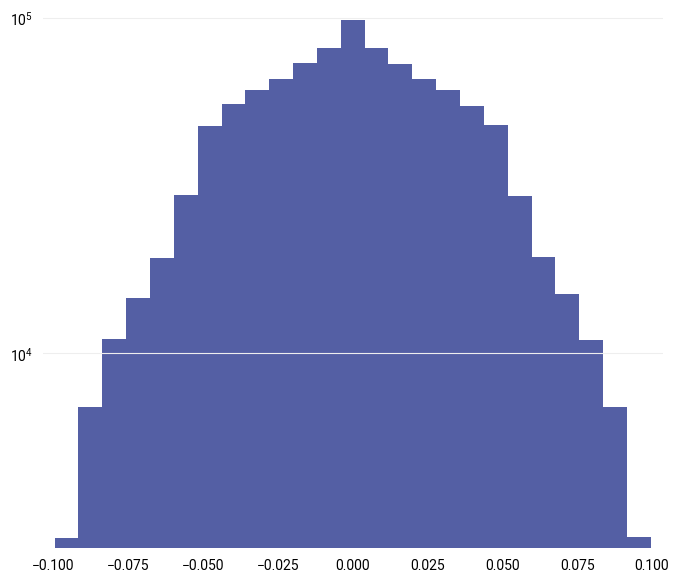

In [11]:
from matplotlib import pyplot as plt

plt.hist(
    (
        ((ERA5_U_sg[:, 2:, :] / 2) - (ERA5_U_sg[:, :-2, :] / 2))
        - ((ERA5_U.values[:, 2:, :] / 2) - (ERA5_U.values[:, :-2, :] / 2))
    ).flatten(),
    bins=25,
    log=True,
)
plt.show()

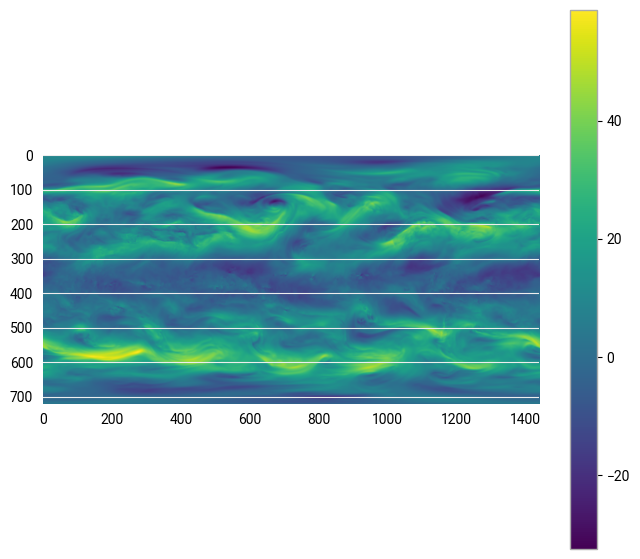

In [12]:
from matplotlib import pyplot as plt

plt.imshow(np.squeeze(ERA5_U_sg))
plt.colorbar()
plt.show()

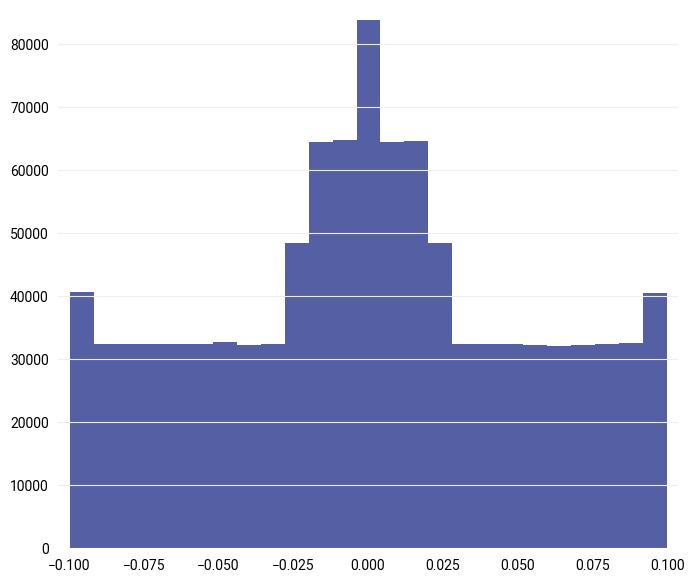

In [13]:
from matplotlib import pyplot as plt

plt.hist((ERA5_U_sg - ERA5_U.values).flatten(), bins=25)
plt.show()

In [14]:
sg_qoi = repr(sg.safeguards[0]._qoi_expr)
sg_qoi

'(X[1] * -0.0 + X[2] * (1 / 2) + X[0] * (-1 / 2))'

In [15]:
import re

sg_progressive_qoi = re.sub(
    r"X\[([^]]+)\]", r'where(C["$progmask"][\1], C["$progdone"][\1], X[\1])', sg_qoi
)
sg_progressive_qoi

'(where(C["$progmask"][1], C["$progdone"][1], X[1]) * -0.0 + where(C["$progmask"][2], C["$progdone"][2], X[2]) * (1 / 2) + where(C["$progmask"][0], C["$progdone"][0], X[0]) * (-1 / 2))'

In [16]:
sg_progressive_qoi_expr = (
    Safeguards(
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi=sg_progressive_qoi,
                neighbourhood=[
                    dict(axis=1, before=1, after=1, boundary="wrap"),
                ],
                type="abs",
                eb=0.1,
            )
        ]
    )
    .safeguards[0]
    ._qoi_expr
)

In [17]:
class MyQoi:
    def __init__(self, wrapped):
        self._wrapped = wrapped

    def compute_data_bounds(self, *args, **kwargs):
        return sg_progressive_qoi_expr.compute_data_bounds(*args, **kwargs)

    def __getattr__(self, name):
        return getattr(self._wrapped, name)

In [18]:
sg_progressive = Safeguards(
    safeguards=[
        dict(
            kind="qoi_eb_stencil",
            qoi="finite_difference(x, order=1, accuracy=2, type=0, axis=0, grid_spacing=1)",
            neighbourhood=[
                dict(axis=1, before=1, after=1, boundary="wrap"),
            ],
            type="abs",
            eb=0.1,
        )
    ]
)
sg_progressive.safeguards[
    0
]._qoi_expr._late_bound_constants = sg_progressive_qoi_expr.late_bound_constants
sg_progressive.safeguards[0]._qoi_expr = MyQoi(sg_progressive.safeguards[0]._qoi_expr)

In [19]:
ERA5_U_sg_progmask = np.zeros_like(ERA5_U.values)
ERA5_U_sg_progcorr = np.empty(
    ERA5_U.values.shape, sg.correction_dtype_for_data(ERA5_U.dtype)
)
ERA5_U_sg_progdone = np.empty_like(ERA5_U.values)

for i in range(3):
    print(i)
    ERA5_U_sg_progressive_correction = sg_progressive.compute_correction(
        ERA5_U.values,
        ERA5_U_prediction,
        late_bound={"$progmask": ERA5_U_sg_progmask, "$progdone": ERA5_U_sg_progdone},
    )
    ERA5_U_sg_progressive_corrected = sg_progressive.apply_correction(
        ERA5_U_prediction, ERA5_U_sg_progressive_correction
    )

    ERA5_U_sg_progcorr[:, i::3, :] = ERA5_U_sg_progressive_correction[:, i::3, :]
    ERA5_U_sg_progdone[:, i::3, :] = ERA5_U_sg_progressive_corrected[:, i::3, :]
    ERA5_U_sg_progmask[:, i::3, :] = True

ERA5_U_sg_progressive_correction = np.copy(ERA5_U_sg_progcorr)
ERA5_U_sg_progressive = sg.apply_correction(
    ERA5_U_prediction, ERA5_U_sg_progressive_correction
)

assert sg.check(ERA5_U.values, ERA5_U_sg_progressive)

0
1
2


In [20]:
ERA5_U_sg_progressive_encoded = correction_codec.encode(
    ERA5_U_sg_progressive_correction
)
print(ERA5_U.nbytes / np.array(ERA5_U_sg_progressive_encoded).nbytes)

5.107287270151413


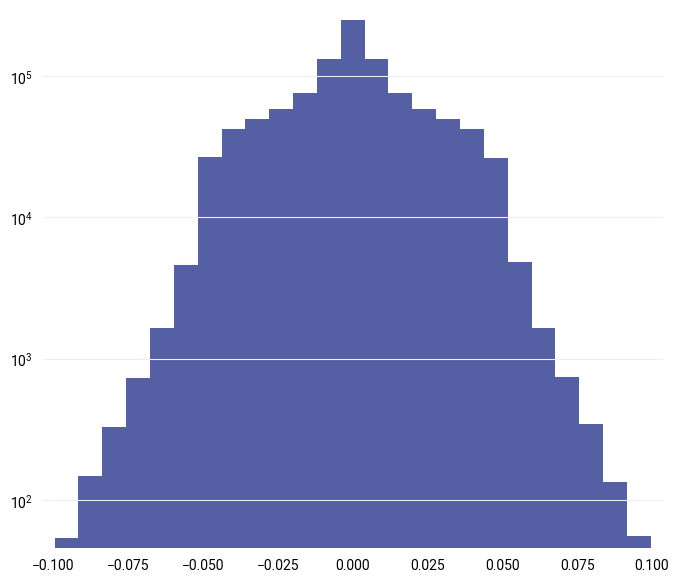

In [21]:
from matplotlib import pyplot as plt

plt.hist(
    (
        ((ERA5_U_sg_progressive[:, 2:, :] / 2) - (ERA5_U_sg_progressive[:, :-2, :] / 2))
        - ((ERA5_U.values[:, 2:, :] / 2) - (ERA5_U.values[:, :-2, :] / 2))
    ).flatten(),
    bins=25,
    log=True,
)
plt.show()

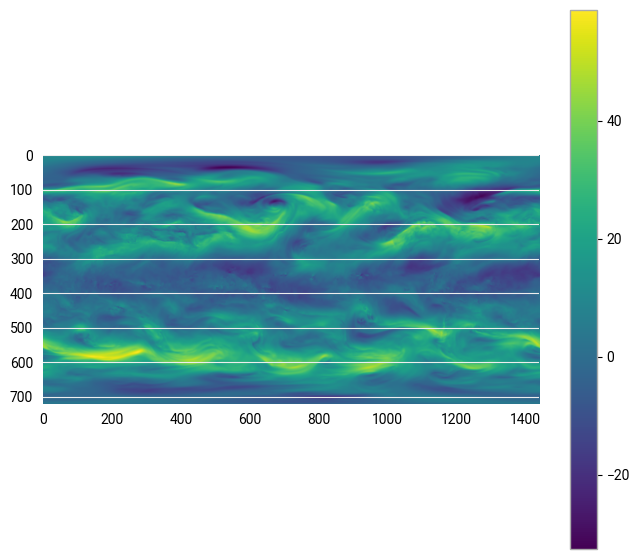

In [22]:
from matplotlib import pyplot as plt

plt.imshow(np.squeeze(ERA5_U_sg_progressive))
plt.colorbar()
plt.show()

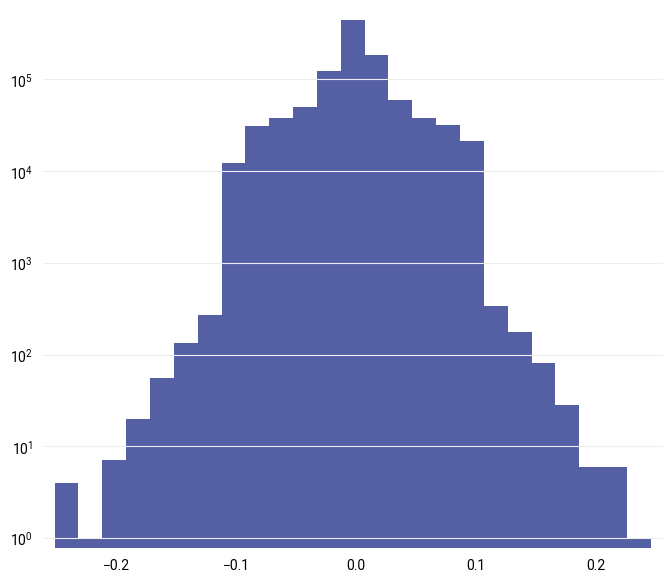

In [23]:
from matplotlib import pyplot as plt

plt.hist((ERA5_U_sg_progressive - ERA5_U.values).flatten(), bins=25, log=True)
plt.show()